In [1]:
import pandas as pd
import numpy as np
data_2 = pd.read_csv('dataset_2.csv')

In [2]:
#Converts each categorical data into one-hot, supllied a data. 
def one_hot(dataset):
    dataset_hot = dataset.copy()
    for column in dataset_hot:
        if column != "adsorption_energy" and type(dataset_hot[column][0])==type('str'):
            onehots = pd.get_dummies(dataset_hot[column], column, drop_first=True, dtype=int)
            dataset_hot = pd.concat([dataset_hot.drop(column, axis=1), onehots], axis=1)
    return dataset_hot

In [3]:
#Does max-min normalization for all numerical attributes. 
def scale_dataset(dataset):
    dataset_scaled = dataset.copy()
    for column in dataset_scaled:
        if column != "adsorption_energy" and type(dataset_scaled[column][0])!=type('str') and type(dataset_scaled[column][0])!=np.bool_:
            min = dataset_scaled[column].min()
            max = dataset_scaled[column].max()
            if min != max:
                dataset_scaled[column]= (dataset_scaled[column] - min) / (max - min)
    return dataset_scaled

In [4]:
data_2 = one_hot(data_2)
data_2 = scale_dataset(data_2)
data_2

,adsorption_energy,fraction,adsorbate_num_atoms,atomic_num_1,atomic_num_2,atomic_num_3,atomic_num_4,atomic_num_5,atomic_num_6,atomic_num_6.1,...,Substrate_Symmetry_2x2,Substrate_Symmetry_2x3,Substrate_Symmetry_2x4,Substrate_Symmetry_3x2,Substrate_Symmetry_3x3,Substrate_Symmetry_4x2,Substrate_Symmetry_4x4,Substrate_Symmetry_c(2x2),Substrate_Symmetry_c(4x4),Substrate_Symmetry_√3x√3
0,-4.29,0.750075,0.000000,0.000000,0,0,0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.56,0.750075,0.045455,0.000000,0,0,0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-3.14,0.500150,0.000000,0.000000,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.50,0.500150,0.045455,0.000000,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.67,0.750075,0.045455,0.000000,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-1.72,0.333333,0.045455,0.083333,0,0,0,0.0,0.1,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1996,1.66,0.333333,0.045455,0.083333,0,0,0,0.0,0.1,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1997,-1.57,0.333333,0.181818,0.250000,0,0,0,0.0,0.1,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1998,-2.51,0.333333,0.136364,0.083333,0,0,0,0.0,0.2,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Neural Networks

In [5]:
#parameters
seed = 12345
train_percent = 0.75

#shuffle data
data_2 = data_2.sample(frac=1, random_state=int(seed))
total_rows = data_2.shape[0]

#divide into training and testing set
training_rows = int(train_percent * total_rows)

# create the training set
training = data_2.iloc[:training_rows, :]
testing = data_2.iloc[training_rows:, :]

#divide into attributes and labels
training_y = training["adsorption_energy"]
training_X = training.drop("adsorption_energy", axis='columns')  
    
testing_y = testing["adsorption_energy"]
testing_X = testing.drop("adsorption_energy", axis='columns')

import tensorflow as tf

# convert to tensors
training_X = tf.convert_to_tensor(training_X, dtype=tf.float32)
training_y = tf.convert_to_tensor(training_y, dtype=tf.int32)
testing_X = tf.convert_to_tensor(testing_X, dtype=tf.float32)
testing_y = tf.convert_to_tensor(testing_y, dtype=tf.float32)

In [6]:
# creates a neural network for regression tasks
def create_reg_network(num_neuron, num_out):
    hidden_layer = tf.keras.layers.Dense(num_neuron, activation='sigmoid')  # 128 hidden neurons
    output_layer = tf.keras.layers.Dense(num_out) # 10 output neurons because there are 10 possible labels for mnist1000 

    all_layers = [hidden_layer, output_layer]
    network = tf.keras.models.Sequential(all_layers)

    return network

In [7]:
# trains a neural network with given training data
def train_reg_network(network, training_X, training_y, learn_rate, num_neuron):
    # create the algorithm that learns the weight of the network (with a learning rate of 0.0001)
    optimizer = tf.keras.optimizers.Adam(learning_rate=float(learn_rate))

    # create the loss function function that tells optimizer how much error it has in its predictions
    loss_function = tf.keras.losses.MeanSquaredError()

    # prepare the network for training
    network.compile(optimizer=optimizer, loss=loss_function, metrics=["mean_absolute_error"])

    # create a logger to save the training details to file
    csv_logger = tf.keras.callbacks.CSVLogger("data_0"+"_"+str(learn_rate)+"_"+str(num_neuron)+".csv")

    # train the network for 200 epochs (setting aside 20% of the training data as validation data)
    network.fit(training_X, training_y, validation_split=0.2, epochs=250, callbacks=[csv_logger])

In [8]:
import numpy as np
learn_rate = 0.0001
num_neuron = 500

network=create_reg_network(num_neuron, 1)
train_reg_network(network, training_X, training_y, float(learn_rate), int(num_neuron))
outputs = network.predict(testing_X)
predictions = outputs.flatten() 
performance = np.mean(np.abs(predictions - testing_y))

Epoch 1/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 12.0393 - mean_absolute_error: 2.8753 - val_loss: 7.0664 - val_mean_absolute_error: 1.9770
Epoch 2/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9976 - mean_absolute_error: 1.9290 - val_loss: 4.5983 - val_mean_absolute_error: 1.5070
Epoch 3/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8992 - mean_absolute_error: 1.6313 - val_loss: 3.6616 - val_mean_absolute_error: 1.4100
Epoch 4/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9915 - mean_absolute_error: 1.5155 - val_loss: 3.3842 - val_mean_absolute_error: 1.4189
Epoch 5/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4574 - mean_absolute_error: 1.4975 - val_loss: 3.2770 - val_mean_absolute_error: 1.4186
Epoch 6/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2661 - mean_absolute_error: 1.4516 - val_loss: 3.2036 - val_mean_absolute_error: 1.4072
Epoch 7/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4736 - mean_absolute_error: 1.5106 - val_los

In [9]:
def mae_calculator(predictions, testing_y):
    n = len(predictions)
    sum = 0
    for x in range(n):
        sum += abs(predictions[x] - testing_y[x])
    return sum/n

In [10]:
def variance_calculator(predictions, testing_y):
    sum = 0
    mae = mae_calculator(predictions, testing_y)
    for i in range(len(predictions)):
        sum += (abs(predictions[i] - testing_y[i])-mae)**2
    n=len(predictions)-1
    return sum/n

In [11]:
def CI(predictions, testing_y):
    mae = mae_calculator(predictions, testing_y)
    variance = variance_calculator(predictions, testing_y)
    n=len(predictions)-1
    interval = 2.24*((variance/n)**0.5)
    low = mae-interval
    high = mae+interval
    return low, high

In [15]:
# get the output of the network for each testing instance
# NOTE: there will be 10 values per instance, one for each output neuron
predictions = network.predict(testing_X)

# calculate the accuracy of the predictions
mae = mae_calculator(predictions, testing_y)
print("Mean Absolute Error:",float(mae))
low, high = CI(predictions, testing_y)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
Mean Absolute Error: 0.8777269124984741


In [16]:
low

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.7934991], dtype=float32)>

In [17]:
high

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9619547], dtype=float32)>

## SVM

### SVM Poly 2

In [36]:
from sklearn.svm import SVR

In [37]:
def mae_calculator(predictions, testing_y):
    n = len(predictions)
    testing_y = pd.array(testing_y)
    sum = 0
    for x in range(n):
        sum += abs(predictions[x] - testing_y[x])
    return sum/n

In [38]:
def variance_calculator(predictions, testing_y):
    sum = 0
    testing_y = pd.array(testing_y)
    predictions = pd.array(predictions)
    mae = mae_calculator(predictions, testing_y)
    for i in range(len(predictions)):
        sum += (abs(predictions[i] - testing_y[i])-mae)**2
    n=len(predictions)-1
    return sum/n

In [39]:
def CI(predictions, testing_y):
    mae = mae_calculator(predictions, testing_y)
    variance = variance_calculator(predictions, testing_y)
    n=len(predictions)-1
    interval = 2.24*((variance/n)**0.5)
    low = mae-interval
    high = mae+interval
    return low, high

In [40]:
#parameters
seed = 12345
train_percent = 0.75

#shuffle data
data_2 = data_2.sample(frac=1, random_state=int(seed))
total_rows = data_2.shape[0]

#divide into training and testing set
training_rows = int(train_percent * total_rows)

# create the training set
training = data_2.iloc[:training_rows, :]
testing = data_2.iloc[training_rows:, :]

#divide into attributes and labels
training_y = training["adsorption_energy"]
training_X = training.drop("adsorption_energy", axis='columns')  
    
testing_y = testing["adsorption_energy"]
testing_X = testing.drop("adsorption_energy", axis='columns')

In [41]:
svm2_model = SVR(kernel='poly', degree=2).fit(training_X, training_y)
predictions_svm2 = svm2_model.predict(testing_X)
predictions_svm2 = pd.array(predictions_svm2)

In [31]:
mae_calculator(predictions_svm2, testing_y)

0.6706153629756975

In [42]:
CI(predictions_svm2, testing_y)

(0.5677420960378669, 0.71578182432379)

### SVM Poly 3

In [43]:
svm3_model = SVR(kernel='poly', degree=3).fit(training_X, training_y)
predictions_svm3 = svm3_model.predict(testing_X)
predictions_svm3 = pd.array(predictions_svm3)

In [44]:
mae_calculator(predictions_svm3, testing_y)

0.6487179023858579

### SVM Poly 4

In [45]:
svm4_model = SVR(kernel='poly', degree=4).fit(training_X, training_y)
predictions_svm4 = svm4_model.predict(testing_X)
predictions_svm4 = pd.array(predictions_svm4)

In [46]:
mae_calculator(predictions_svm4, testing_y)

0.6949559964832472

### SVM Poly RBF

In [47]:
svmrbf_model = SVR(kernel='rbf').fit(training_X, training_y)
predictions_rbf = svmrbf_model.predict(testing_X)
predictions_rbf = pd.array(predictions_rbf)

In [48]:
mae_calculator(predictions_rbf, testing_y)

0.6396744907292955

In [49]:
CI(predictions_rbf, testing_y)

(0.56489956366889, 0.714449417789701)

## Decision Trees

In [50]:
from sklearn.tree import DecisionTreeRegressor

In [51]:
tree_model = DecisionTreeRegressor().fit(training_X, training_y)
predictions_tree = tree_model.predict(testing_X)
predictions_tree = pd.array(predictions_tree)

In [52]:
mae_calculator(predictions_tree, testing_y)

0.5595151587301586

In [54]:
CI(predictions_tree, testing_y)

(0.4806598587544239, 0.6383704587058932)

In [55]:
from sklearn import tree

In [56]:
features = pd.DataFrame(data_2.columns)
features = features[0].tolist()
features.pop(0)

'adsorption_energy'

In [57]:
features

['fraction',
 'adsorbate_num_atoms',
 'atomic_num_1',
 'atomic_num_2',
 'atomic_num_3',
 'atomic_num_4',
 'atomic_num_5',
 'atomic_num_6',
 'atomic_num_6.1',
 'atomic_num_8',
 'atomic_num_9',
 'atomic_num_10',
 'atomic_num_1.1',
 'atomic_num_12',
 'atomic_num_13',
 'atomic_num_14',
 'atomic_num_15',
 'atomic_num_16',
 'atomic_num_17',
 'atomic_num_18',
 'atomic_num_19',
 'atomic_num_20',
 'atomic_num_21',
 'atomic_num_22',
 'atomic_num_23',
 'atomic_num_24',
 'atomic_num_25',
 'atomic_num_26',
 'atomic_num_27',
 'atomic_num_28',
 'atomic_num_29',
 'atomic_num_30',
 'double',
 'triple',
 'termination_atomic_num',
 'Fixed_Substrate',
 'LatticeConstant1',
 'facet',
 'adsorbate_formula_B',
 'adsorbate_formula_C',
 'adsorbate_formula_C(O)C(O)C',
 'adsorbate_formula_C(O)C(O)C(O)',
 'adsorbate_formula_C(O)CCO',
 'adsorbate_formula_C(O)CH(O)C(O)',
 'adsorbate_formula_C(O)CHOHC(O)',
 'adsorbate_formula_C(O)CO',
 'adsorbate_formula_C(O)COHC',
 'adsorbate_formula_C(O)COHC(O)',
 'adsorbate_formula

In [58]:
text_representation = tree.export_text(tree_model, feature_names=features)
print(text_representation)

|--- adsorbate_num_atoms <= 0.02
|   |--- atomic_num_1 <= 0.04
|   |   |--- adsorbate_formula_C <= 0.50
|   |   |   |--- fraction <= 0.09
|   |   |   |   |--- termination_atomic_num <= 0.54
|   |   |   |   |   |--- termination_Cu <= 0.50
|   |   |   |   |   |   |--- termination_atomic_num <= 0.41
|   |   |   |   |   |   |   |--- value: [-0.48]
|   |   |   |   |   |   |--- termination_atomic_num >  0.41
|   |   |   |   |   |   |   |--- value: [0.09]
|   |   |   |   |   |--- termination_Cu >  0.50
|   |   |   |   |   |   |--- value: [0.92]
|   |   |   |   |--- termination_atomic_num >  0.54
|   |   |   |   |   |--- termination_atomic_num <= 0.77
|   |   |   |   |   |   |--- termination_atomic_num <= 0.55
|   |   |   |   |   |   |   |--- value: [1.43]
|   |   |   |   |   |   |--- termination_atomic_num >  0.55
|   |   |   |   |   |   |   |--- value: [1.81]
|   |   |   |   |   |--- termination_atomic_num >  0.77
|   |   |   |   |   |   |--- value: [1.30]
|   |   |   |--- fraction >  0.09
|

[Text(0.4262484827208789, 0.9875, 'adsorbate_num_atoms <= 0.023\nsquared_error = 4.361\nsamples = 1500\nvalue = -1.795'),
 Text(0.2275236028939443, 0.9625, 'atomic_num_1 <= 0.042\nsquared_error = 3.745\nsamples = 497\nvalue = -3.187'),
 Text(0.14518735549599854, 0.9375, 'adsorbate_formula_C <= 0.5\nsquared_error = 4.064\nsamples = 290\nvalue = -3.985'),
 Text(0.08910749079914124, 0.9125, 'fraction <= 0.094\nsquared_error = 3.354\nsamples = 260\nvalue = -3.652'),
 Text(0.044660170469647625, 0.8875, 'termination_atomic_num <= 0.536\nsquared_error = 0.568\nsamples = 10\nvalue = 0.932'),
 Text(0.04230874621036636, 0.8625, 'termination_Cu <= 0.5\nsquared_error = 0.303\nsamples = 5\nvalue = 0.308'),
 Text(0.041133034080725724, 0.8375, 'termination_atomic_num <= 0.407\nsquared_error = 0.08\nsamples = 3\nvalue = -0.1'),
 Text(0.0399573219510851, 0.8125, 'squared_error = 0.0\nsamples = 1\nvalue = -0.48'),
 Text(0.04230874621036636, 0.8125, 'squared_error = 0.012\nsamples = 2\nvalue = 0.09'),
 T

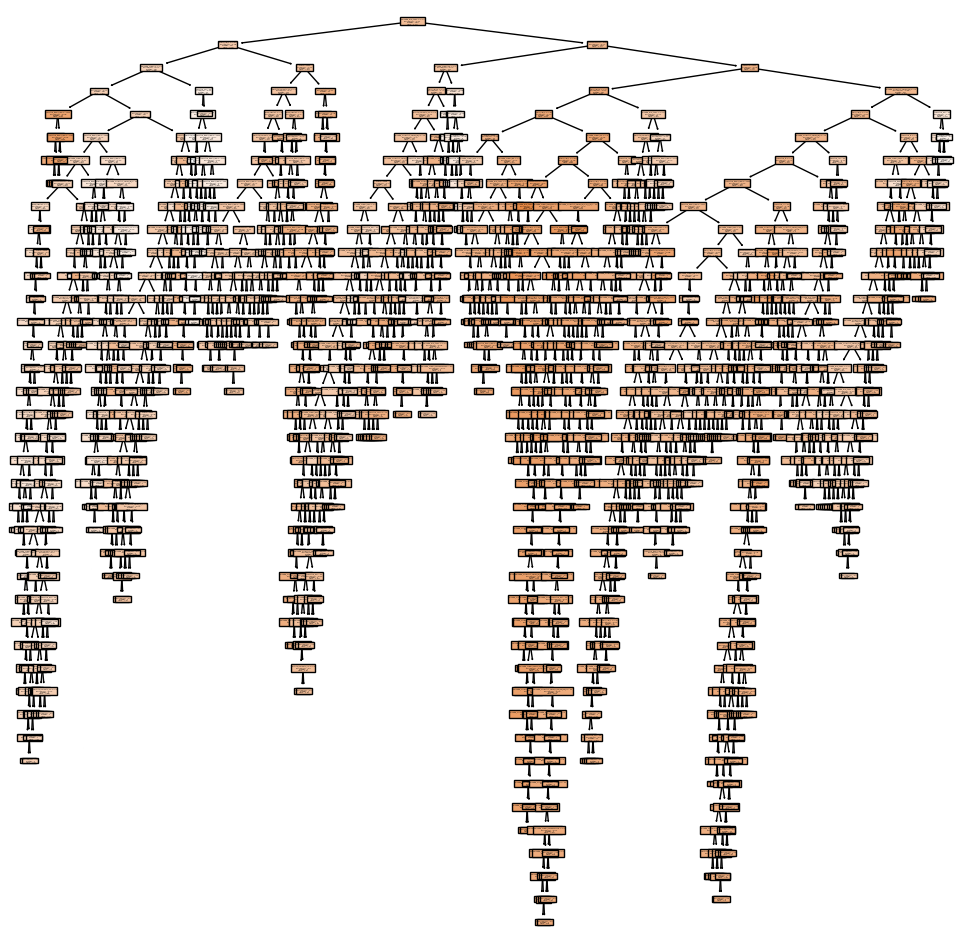

In [60]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
tree.plot_tree(tree_model, feature_names=features, filled=True)

## Random Forrest

In [61]:
from sklearn.ensemble import RandomForestRegressor
forrest_model = RandomForestRegressor(max_depth=2, random_state=0)
forrest_model = RandomForestRegressor().fit(training_X, training_y)
predictions_forrest = forrest_model.predict(testing_X)
predictions_forrest = pd.array(predictions_forrest)

In [62]:
mae_calculator(predictions_forrest, testing_y)

0.4962690157345283

In [64]:
CI(predictions_forrest, testing_y)

(0.4276731607895072, 0.5648648706795494)

## Linear Regression

In [65]:
from sklearn.linear_model import LinearRegression

In [66]:
linear_model = LinearRegression().fit(training_X, training_y)
predictions_linear = linear_model.predict(testing_X)
predictions_linear = pd.array(predictions_linear)

In [67]:
mae_calculator(predictions_linear, testing_y)

983736720826.1038

In [68]:
CI(predictions_linear, testing_y)

(553515846700.9316, 1413957594951.276)

## LASSO

In [29]:
from sklearn.linear_model import Lasso

In [30]:
lasso_model = Lasso().fit(training_X, training_y)
predictions_lasso = lasso_model.predict(testing_X)
predictions_lasso = pd.array(predictions_lasso)

In [31]:
mae_calculator(predictions_lasso, testing_y)

1.7147718399999994

## Ridge

In [32]:
from sklearn.linear_model import Ridge

In [33]:
ridge_model = Ridge().fit(training_X, training_y)
predictions_ridge = ridge_model.predict(testing_X)
predictions_ridge = pd.array(predictions_ridge)

In [34]:
mae_calculator(predictions_ridge, testing_y)

0.7573951107226292

# Data Analysis

In [75]:
overal_performance =  {'model': ['random forrest','Decision Tree','SVM_rbf', 'Neural Net'], 
                'Mean Absolute Error': [0.50, 0.56, 0.64, 0.88]}

In [76]:
overal_performance = pd.DataFrame(data=overal_performance)

In [77]:
from plotnine import *

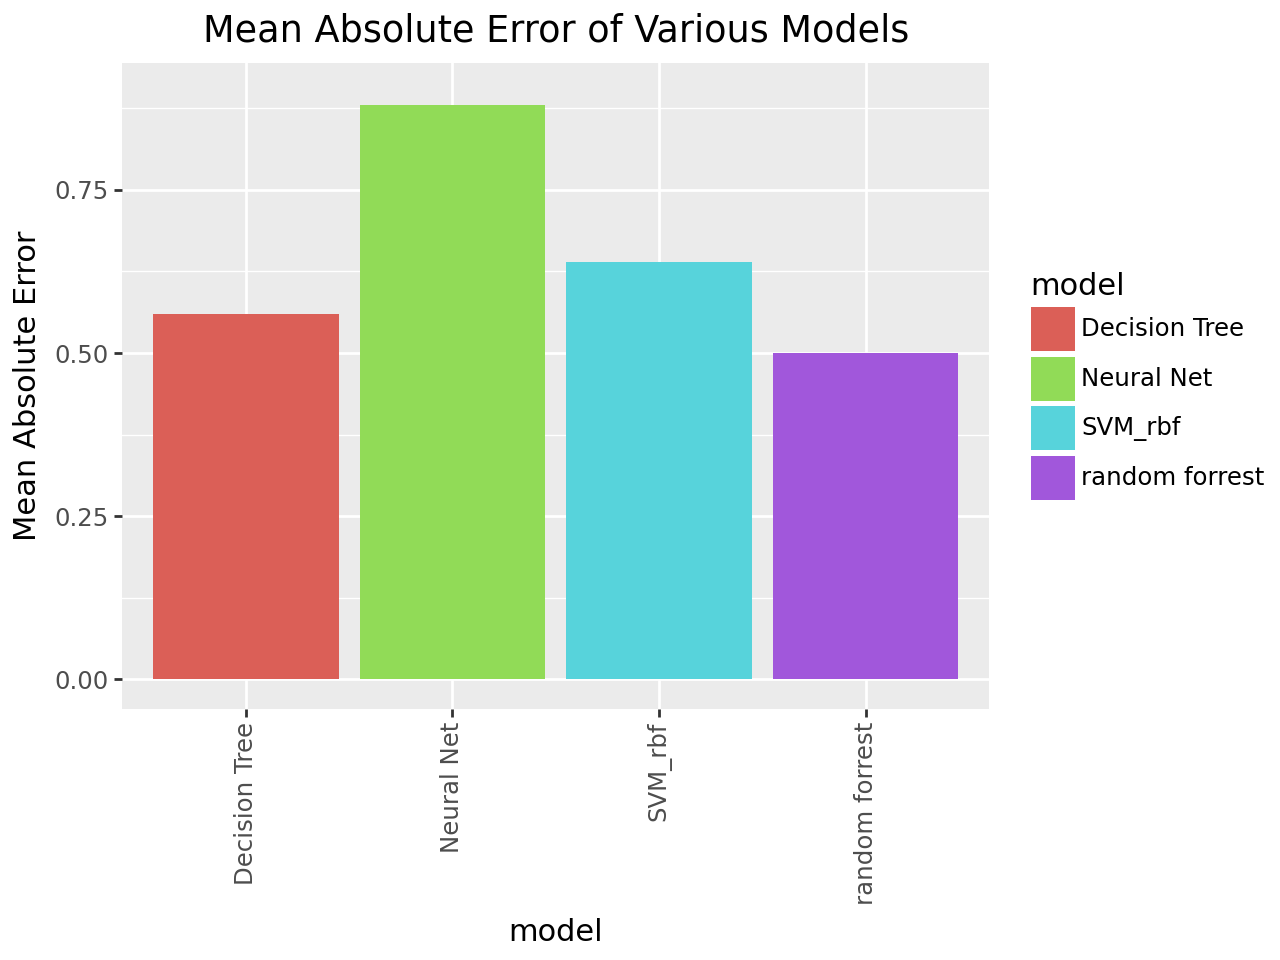

In [80]:
bar_chart = (
    ggplot(overal_performance) 
        + aes(x="model", y="Mean Absolute Error", fill='model')
        + geom_col(position="dodge")
        + ylim(0, 0.9)
        + theme(axis_text_x = element_text(angle=90, hjust=5))
        + ggtitle("Mean Absolute Error of Various Models")
)
bar_chart